In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from openbb import obb
from scipy.stats import spearmanr

In [3]:
obb.user.preferences.output_type = "dataframe"

In [4]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]

In [6]:
data = obb.equity.price.historical(
    symbols, start_date="2015-01-01", end_date="2022-12-31",
    provider="cboe",
)

In [7]:
prices = data[["high", "low", "close", "volume", "symbol"]]

In [8]:
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.symbol.isin(mask)]

In [9]:
prices = (
    prices.set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
    .sort_index(level=0)
).drop_duplicates()

In [10]:

def parkinson(data, window=14, trading_days=252):
    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log)) ** 2.0

    def f(v):
        return (trading_days * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    return result.sub(result.mean()).div(result.std())

In [11]:
prices["vol"] = prices.groupby("symbol", group_keys=False).apply(parkinson)
prices.dropna(inplace=True)

In [12]:
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = prices.groupby(level="symbol").close.pct_change(lag)

In [13]:
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = prices.groupby(level="symbol")[f"return_{t}d"].shift(-t)

In [14]:
display(prices)


high     low   close   volume       vol  return_1d  \
symbol date                                                               
CDE    2015-01-22    6.43    6.15    6.31  3404900  0.504497        NaN   
       2015-01-23    6.25    5.93    5.99  2234133  0.468407  -0.050713   
       2015-01-26    6.13    5.69    6.11  2149829  0.515128   0.020033   
       2015-01-27    6.42    6.12    6.32  3697786  0.510313   0.034370   
       2015-01-28    6.36    5.89    5.99  2668277  0.490500  -0.052215   
...                   ...     ...     ...      ...       ...        ...   
UNH    2022-12-23  531.31  522.90  531.31  1291931 -0.474862   0.008006   
       2022-12-27  535.84  529.84  531.99  1596531 -0.477496   0.001280   
       2022-12-28  538.15  527.73  528.45  1694354 -0.427154  -0.006654   
       2022-12-29  533.68  528.86  529.88  1379520 -0.448415   0.002706   
       2022-12-30  530.50  524.84  530.18  1849277 -0.488940   0.000566   

                   return_5d  return_10d  return_21d  return_42d  return_63d  \
symbol date                                                                    
CDE    2015-01-22        NaN         NaN         NaN         NaN         NaN   
       2015-01-23        NaN         NaN         NaN         NaN         NaN   
       2015-01-26        NaN         NaN         NaN         NaN         NaN   
       2015-01-27        NaN         NaN         NaN         NaN         NaN   
       2015-01-28        NaN         NaN         NaN         NaN         NaN   
...                      ...         ...         ...         ...         ...   
UNH    2022-12-23   0.014531   -0.014633    0.003021   -0.016493    0.045145   
       2022-12-27   0.016024   -0.025409   -0.010472   -0.020583    0.046462   
       2022-12-28   0.015840   -0.018152   -0.007177   -0.024640    0.028233   
       2022-12-29   0.004436   -0.015752    0.003561   -0.038749    0.041369   
       2022-12-30   0.005862    0.004738   -0.032094   -0.044979    0.049778   

                   target_1d  target_5d  target_10d  target_21d  target_42d  \
symbol date                                                                   
CDE    2015-01-22  -0.050713  -0.058637    0.145800   -0.083994   -0.133122   
       2015-01-23   0.020033   0.051753    0.170284   -0.083472   -0.118531   
       2015-01-26   0.034370   0.045827    0.189853   -0.094926   -0.147300   
       2015-01-27  -0.052215   0.036392    0.136076   -0.115506   -0.202532   
       2015-01-28  -0.008347   0.188648    0.158598   -0.025042   -0.191987   
...                      ...        ...         ...         ...         ...   
UNH    2022-12-23   0.001280        NaN         NaN         NaN         NaN   
       2022-12-27  -0.006654        NaN         NaN         NaN         NaN   
       2022-12-28   0.002706        NaN         NaN         NaN         NaN   
       2022-12-29   0.000566        NaN         NaN         NaN         NaN   
       2022-12-30        NaN        NaN         NaN         NaN         NaN   

                   target_63d  
symbol date                    
CDE    2015-01-22   -0.118859  
       2015-01-23   -0.136895  
       2015-01-26   -0.067103  
       2015-01-27   -0.106013  
       2015-01-28   -0.086811  
...                       ...  
UNH    2022-12-23         NaN  
       2022-12-27         NaN  
       2022-12-28         NaN  
       2022-12-29         NaN  
       2022-12-30         NaN  

[16020 rows x 17 columns]

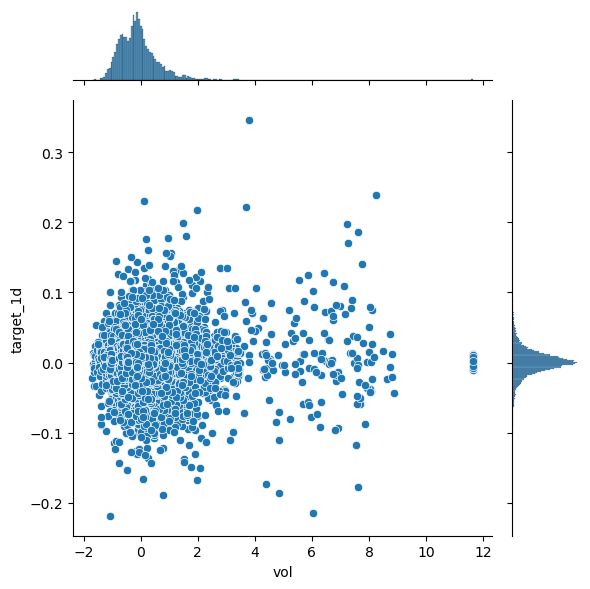

In [15]:
target = "target_1d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()